In [1]:
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.nn import Module, Sequential, PReLU, Linear, Conv2d
import torchaudio

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from loguru import logger

## Load configurations

In [15]:
from hydra import initialize, compose

with initialize(config_path="./"):
    cfg = compose('config.yaml')

## Data checking

torch.Size([67277]) 16000
tensor([-0.0731, -0.0750, -0.0746, -0.0750, -0.0750, -0.0759, -0.0750, -0.0750,
        -0.0746, -0.0753, -0.0746, -0.0750, -0.0756, -0.0753, -0.0750, -0.0743,
        -0.0753, -0.0759, -0.0756, -0.0762])
0: h# 0.150625
1: sh 0.29375
2: iy 0.3975
3: hv 0.485625
4: ae 0.6575
5: dcl 0.750625
6: jh 0.788125
7: axr 0.9175
8: dcl 1.053125
9: d 1.066875
10: aa 1.2308125
11: r 1.3175
12: kcl 1.44125
13: k 1.455
14: s 1.59625
15: ux 1.7725
16: tcl 1.8525
17: t 1.884375
18: ih 1.9425
19: n 2.01925
20: gcl 2.07125
21: g 2.095625
22: r 2.152875
23: iy 2.250625
24: z 2.350625
25: iy 2.415125
26: w 2.556125
27: ao 2.7035625
28: r 2.758375
29: sh 3.058125
30: epi 3.195
31: w 3.2458125
32: ao 3.3475
33: dx 3.3725
34: axr 3.5364375
35: ao 3.69575
36: l 3.7775
37: y 3.8471875
38: ih 3.949
39: axr 4.0375


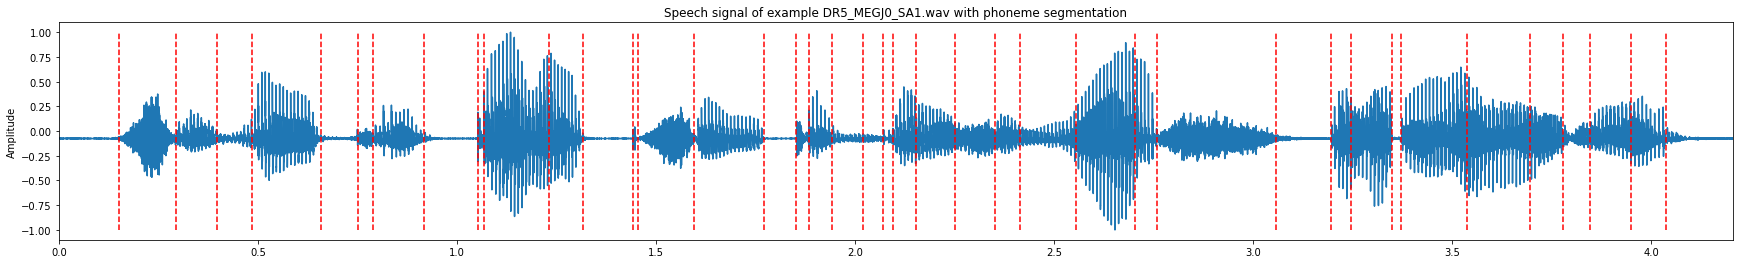

In [16]:
# Load data
signalData, samplingFrequency = torchaudio.load(cfg.wav_path, normalize=False)
signalData = signalData[0]

# Normalize data
signalData = 2 * (signalData - torch.min(signalData)) / (torch.max(signalData) - torch.min(signalData)) - 1 

print(signalData.shape, samplingFrequency)
print(signalData[:20])

# Read phoneme segmentation and annotation
with open(cfg.phn_path, 'r') as fp:
    lines = fp.readlines()
    lines = list(map(lambda line: line.split(" "), lines))

times = list(map(lambda line: int(line[1]), lines))[:-1]
labels = list(map(lambda line: line[2].strip(), lines))[:-1]

for i, (label, time) in enumerate(zip(labels, times)):
    print(f'{i}:', label, time / samplingFrequency)

x = np.array(list(range(len(signalData)))) / samplingFrequency
x_end = len(signalData) / samplingFrequency

plt.figure(figsize=(30, 4))
plt.title(f'Speech signal of example {cfg.file_name}.wav with phoneme segmentation')
plt.plot(x, signalData)
plt.xlim((0.0, x_end))
plt.ylabel('Amplitude')
for time in times:
    plt.vlines(time / samplingFrequency, -1, 1, colors = "r", linestyles = "dashed")
plt.show()

## Data Processing

In [3]:
from data_processing import TimitDataset, print_list, collate_fn_pad

In [4]:
def test_dataloader(cfg):
    if_dev_run = cfg.dev_run
    cfg.dev_run = True
    spect, _, _, _, phoneme_labels, _ = TimitDataset('C:/Users/Xianda/Downloads', cfg).process_file(cfg.wav_path)
    print(spect.shape, phoneme_labels.shape)
    print(spect[:5])
    # print(phoneme_labels.argmax(1))
    print_list(phoneme_labels.argmax(1), 25)

    # TimitDataset(os.path.join(cfg.dataset_path, 'train'), cfg)

    # print(cfg.ckpt_path)
    cfg.dev_run = if_dev_run

test_dataloader(cfg)

2022-05-19 01:36:49.608 | INFO     | data_processing:__init__:77 - Loading 0 files into cache ...
0it [00:00, ?it/s]


(293, 1, 13, 9) (293, 39)
[[[[-5.50275085e+02 -5.50275085e+02 -5.50275085e+02 -5.50275085e+02
    -5.50275085e+02 -5.50275085e+02 -2.09023956e+02 -3.71056335e+02
    -2.08682495e+02]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00  5.43501587e+01  4.80090332e+01
     5.38326569e+01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00  1.21049519e+01  1.72216167e+01
     1.20948009e+01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00  1.22101402e+01  1.37104979e+01
     1.20399380e+01]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00  7.66639185e+00  1.75929146e+01
     7.26140404e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
     0.00000000e+00  0.00000000e+00  6.43850040e+00  1.36706820e+01
     6.63819885e+00]
   [ 0.00000000e+00  0.00000000e

## Model Definition

In [5]:
class Segmentor(Module):
    def __init__(self, hparams):
        super(Segmentor, self).__init__()
        self.hparams = hparams

        self.encoder = Sequential(
            Conv2d(1, hparams.z_dim, kernel_size=(hparams.k_1_h, hparams.k_1_w)),
            PReLU(),
            Conv2d(hparams.z_dim, hparams.z_dim * 2, kernel_size=(hparams.k_2_h, hparams.k_2_w)),
            PReLU()
        )

        self.classifier = Sequential(
            Linear(hparams.fc_input, hparams.fc_hidden_1),
            PReLU(),
            Linear(hparams.fc_hidden_1, hparams.fc_hidden_2),
            PReLU(),
            Linear(hparams.fc_hidden_2, hparams.n_classes),
        )

    def forward(self, spect):
        encoded = self.encoder(spect)
        encoded = torch.flatten(encoded, 1)

        cls_out = self.classifier(encoded)

        return cls_out

In [6]:
def test_model(cfg):
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

    conv1 = Conv2d(1, cfg.z_dim, kernel_size=(cfg.k_1_h, cfg.k_1_w))
    conv2 = Conv2d(cfg.z_dim, cfg.z_dim * 2, kernel_size= (cfg.k_2_h, cfg.k_2_w))
    input_data = torch.randn(246, 1, 13, 9)
    conv1_output = conv1(input_data)
    print(conv1_output.shape)
    conv2_output = conv2(conv1_output)
    print(conv2_output.shape)
    print(32 * 7 * 7)

## Training & Testing

In [6]:
def train_loop(epoch_i, dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    total_loss = 0
    with tqdm(total=size, desc=f'epoch {epoch_i}') as t:
        for i, (X, _, _, _, y_class, _) in enumerate(dataloader):
            output = model(X)
            loss = loss_fn(output, y_class)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            t.set_postfix_str(f'loss={total_loss / (i + 1):>7.3f}')
            t.update()

    return total_loss / size

def get_img_from_logits(logits, cmap, alpha):
    img = np.ones((logits.shape[1], logits.shape[0], 4))
    for i, log in enumerate(logits):
        img[:, i, :3] = np.transpose(np.array([log]).transpose(1, 0) * cmap, (1, 0)).transpose(1, 0)
        img[:, i, -1] = [alpha] * np.shape(logits)[1]
    return img

def print_val(file_name, targets, labels, preds, logits):
    print("Wav File:", file_name, f"Accuracy: {sum([x == y for x, y in zip(targets, preds)]) / len(targets) * 100:2.2f}%")
    print("Ground Truth:")
    print_list(targets)
    print("Prediction:")
    print_list(preds)

    logits_img = get_img_from_logits(logits, [0, 1, 0], 1)
    gt_img = get_img_from_logits(labels, [0, 1, 0], 1)

    figs, axes = plt.subplots(2, sharex=True, figsize=(30, 4))

    axes[0].set_title('Ground Truth')
    axes[0].imshow(gt_img)
    axes[1].set_title('Prediction')
    axes[1].imshow(logits_img)
    plt.show()

def validate(dataloader, model, loss_fn):
    size = len(dataloader)
    val_loss = 0
    pred_list, logits_list, target_list, label_list, wav_list = [], [], [], [], []

    with torch.no_grad():
        for X, _, _, _, y_class, wav_file in dataloader:
            output = model(X)
            val_loss += loss_fn(output, y_class).item()
            pred, gt = output.argmax(1), y_class.argmax(1)
            logits_list.append(torch.sigmoid(output.cpu()).numpy())
            label_list.append(y_class.cpu().numpy())
            pred_list.append(pred.tolist())
            target_list.append(gt.tolist())
            wav_list.append(wav_file)

    val_loss /= size
    val_acc, val_pre, val_recall, val_f1 = report_func(target_list, pred_list)

    logger.info(f"Val Result: Avg loss: {val_loss:>7.3f} Accuracy: {(100*val_acc):>4.1f}% Precision: {(100*val_pre):>4.1f}% Recall: {val_recall:>5.3f} F1: {val_f1:>5.3f}")

    idx = np.random.randint(0, size)
    print_val(wav_list[idx].rsplit('\\', 1)[1], target_list[idx], label_list[idx], pred_list[idx], logits_list[idx])

    return val_loss, val_acc, val_pre, val_recall, val_f1

def report_func(pred, target):
    batch_size = len(pred)
    acc, pre, recall, f1 = 0, 0, 0, 0

    for i in range(batch_size):
        acc += accuracy_score(target[i], pred[i])
        pre += precision_score(target[i], pred[i], average='micro')
        recall += recall_score(target[i], pred[i], zero_division=0, average='micro')
        f1 += f1_score(target[i], pred[i], zero_division=0, average='micro')

    acc /= batch_size
    pre /= batch_size
    recall /= batch_size
    f1  /= batch_size
    return acc, pre, recall, f1

In [7]:
torch.cuda.set_device(cfg.device_id)

if not os.path.exists(cfg.output_path):
    os.makedirs(cfg.output_path, exist_ok=True)

### Train

#### Load train Data

In [9]:
train_dataset, val_dataset = TimitDataset.get_train_dataset(cfg.dataset_path, cfg)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_pad, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn_pad)

2022-05-19 00:52:50.412 | INFO     | data_processing:__init__:77 - Loading 4620 files into cache ...
100%|██████████| 4620/4620 [10:13<00:00,  7.53it/s]


#### Run train loop

2022-05-19 01:03:09.911 | INFO     | __main__:<module>:9 - Model initiated.
2022-05-19 01:03:09.911 | INFO     | __main__:<module>:11 - Training started.


----------------------------


epoch 0: 100%|██████████| 4158/4158 [00:21<00:00, 192.41it/s, loss=  1.789]
2022-05-19 01:03:32.564 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.598 Accuracy: 59.1% Precision: 59.1% Recall: 0.591 F1: 0.591


Wav File: DR8_MEJS0_SX340.WAV Accuracy: 53.96%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
10, 10, 10, 10,  7,  7,  7,  7, 36, 36, 36, 36, 36, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 29, 15, 15, 15, 15, 15, 15, 15, 13, 13, 13, 13, 13, 13, 13, 13,  0,  0,  0,  0,  0, 
 0,  0,  0,  0,  0,  0,  0, 10, 10, 10, 10, 10,  9,  9,  9, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 
18, 18, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 35, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 26, 26, 26, 31, 
31, 31, 31, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 
16, 16, 16, 16, 16, 16, 16, 18, 18, 18, 18, 18, 18, 18, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 18, 
18, 18, 18, 18, 18, 18, 18, 18, 18, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 19, 
19, 16, 16, 16, 16, 16, 16, 16

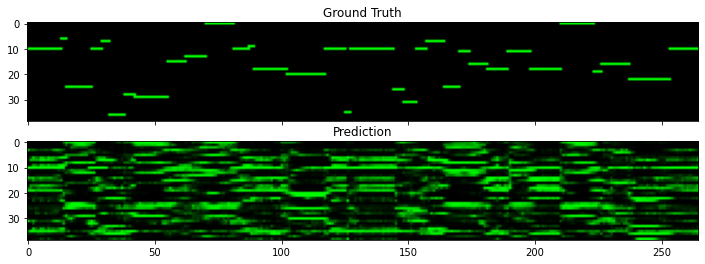

epoch 1: 100%|██████████| 4158/4158 [00:14<00:00, 278.70it/s, loss=  1.544]
2022-05-19 01:03:48.650 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.531 Accuracy: 60.8% Precision: 60.8% Recall: 0.608 F1: 0.608


Wav File: DR4_MJLS0_SI1726.WAV Accuracy: 55.06%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0, 31, 31, 31, 10, 10, 10, 10,  3, 
 3,  3,  3,  3,  3,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
31, 31, 31, 31, 31, 31, 35, 35, 35, 35, 35, 35, 35,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 11, 11, 
11, 11, 11, 11, 36, 36, 36, 36, 36, 36, 36, 36, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 
21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 
30, 22, 22, 22, 22, 22, 10, 10, 10, 15, 15, 15, 15, 15, 15, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7, 21, 21, 30, 30, 30,  3,  3,  3,  3,  3,  3, 
 3,  3,  3, 10, 10, 10, 10, 1

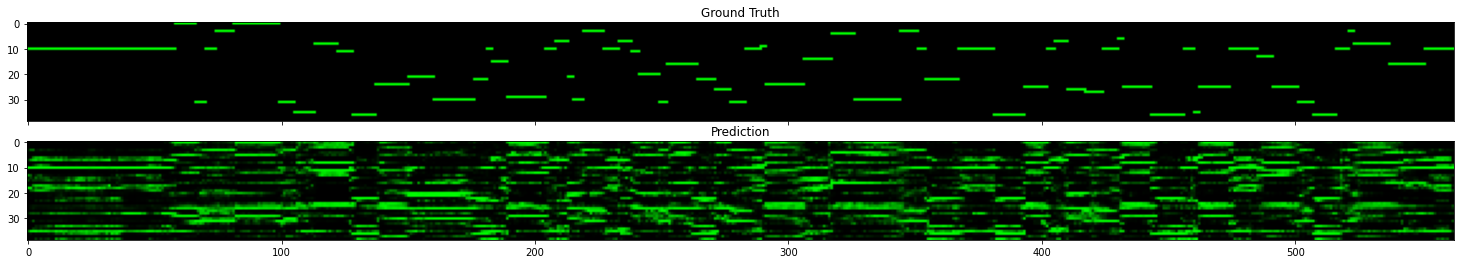

epoch 2: 100%|██████████| 4158/4158 [00:15<00:00, 275.00it/s, loss=  1.461]
2022-05-19 01:04:04.918 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.502 Accuracy: 61.6% Precision: 61.6% Recall: 0.616 F1: 0.616


Wav File: DR3_MDLC0_SA2.WAV Accuracy: 67.59%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6, 24, 24, 24, 24, 24, 24, 24, 24, 24, 
24, 24, 24, 24, 24, 24, 24, 24, 31, 31, 31, 35, 35, 35, 35, 35, 35, 35, 35, 29, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 
 7,  7,  7,  7,  3,  3,  3,  3,  3,  3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 35, 30, 30, 30, 10, 10, 10, 10, 10, 10, 
10, 10,  7,  7,  7,  7,  7,  7,  7,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,  4,  4,  4,  4, 20, 
20, 20, 20, 20, 20, 26, 26, 26, 31, 31, 31, 31,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 
 2,  2,  2,  2,  2,  2, 11, 11, 11, 11, 20, 20, 20, 20, 20, 20, 20,  4,  4,  4,  4,  4,  4,  4,  4, 
 4,  4,  4,  4, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 
10, 10, 10, 10, 10, 34, 34, 11, 

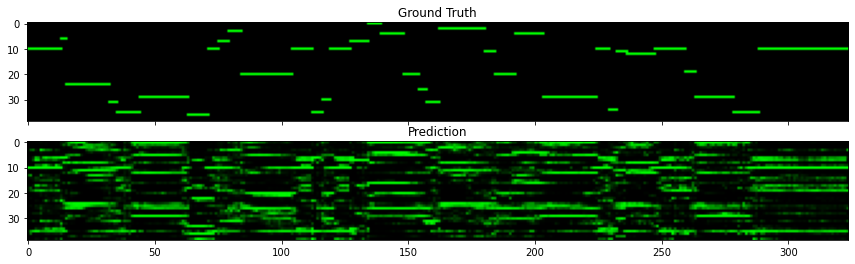

epoch 3: 100%|██████████| 4158/4158 [00:16<00:00, 258.44it/s, loss=  1.404]
2022-05-19 01:04:22.119 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.500 Accuracy: 61.2% Precision: 61.2% Recall: 0.612 F1: 0.612


Wav File: DR8_MMLM0_SX177.WAV Accuracy: 68.18%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6, 25, 
25, 25, 25, 25, 25, 25, 25, 25, 22, 22, 22, 22, 22, 22, 22, 22, 10, 10, 10, 10, 10, 10,  7,  7,  7, 
 7,  7,  7,  7,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 24, 24, 24, 24, 24, 24, 24, 24, 11, 11, 11, 
11, 11, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7, 37, 37, 37, 37, 37, 10, 10, 10,  7,  7, 
 7,  7,  7, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 21, 21, 21, 21, 21, 21, 21, 30, 30, 
30, 30, 30, 30, 30, 30, 30, 22, 22, 22, 22, 22, 22, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7, 
 7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6, 26, 
24, 24,  0,  0,  0,  0,  0

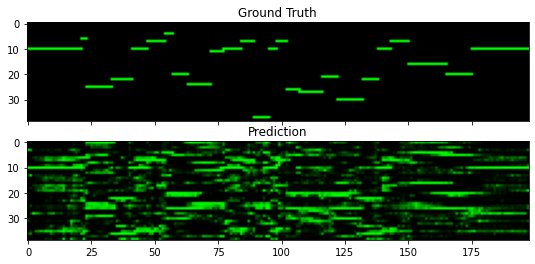

epoch 4: 100%|██████████| 4158/4158 [00:15<00:00, 276.15it/s, loss=  1.357]
2022-05-19 01:04:38.243 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.511 Accuracy: 61.6% Precision: 61.6% Recall: 0.616 F1: 0.616


Wav File: DR7_MTML0_SI1695.WAV Accuracy: 61.25%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35,  0,  0,  0,  0, 31, 31, 31, 31, 26, 
26, 26, 26, 26, 26, 26, 26, 14, 14, 14, 14, 14, 14, 14, 14, 26, 26, 26, 26, 26, 26, 26, 26, 26, 31, 
31, 26, 26, 26, 26, 26, 26, 10, 10, 10, 10, 10,  6,  6,  6, 30, 30, 30, 30, 30, 13, 13, 13, 13, 13, 
25, 25, 25, 19, 19, 19, 25, 25, 25, 25, 25, 31, 31, 31, 31,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 
 5,  5,  5,  5, 36, 36, 36, 36, 36, 36, 25, 25, 25, 25, 25, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 
10, 10, 10, 10, 10, 17,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 
 5,  5,  5,  5, 10, 10, 10, 22, 22, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9, 29, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 29, 29, 29, 10, 10, 10,  6,  6,  6, 11, 11, 11, 11, 25, 25, 25, 25, 25, 25, 25, 25, 
25, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 1

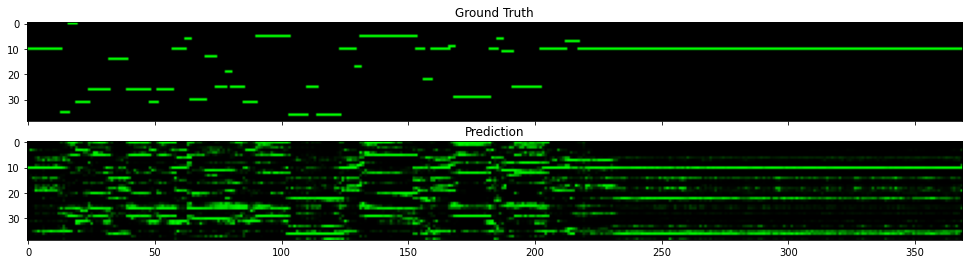

epoch 5: 100%|██████████| 4158/4158 [00:14<00:00, 277.35it/s, loss=  1.315]
2022-05-19 01:04:54.394 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.484 Accuracy: 62.3% Precision: 62.3% Recall: 0.623 F1: 0.623


Wav File: DR7_FPAB1_SX211.WAV Accuracy: 60.96%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 
24, 24, 24, 24, 24, 24, 31, 31, 31, 11, 11, 11, 11, 26, 26, 26, 26, 26, 26, 19, 19, 19, 19, 19, 19, 
26, 26, 26, 26, 26, 10, 10, 10, 10, 10, 10,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
 0,  0, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 17, 17, 17, 17, 17, 17, 
11, 11, 11, 11, 11, 11,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 16, 16, 16, 16, 16, 16, 
16, 16, 16, 16, 16, 16, 22, 22, 22, 22, 22, 22, 22, 22, 22, 31, 31, 31, 31, 31, 31, 31, 31, 31, 10, 
10, 10, 23, 23, 23, 23, 23, 23,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 
 2,  2,  2,  2,  2,  2,  2, 10, 10, 10, 10, 10, 10, 17, 17, 17, 17, 17, 17,  8,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 17, 17, 17, 26, 26, 26, 11, 11, 11, 11, 11, 11, 11,  0, 
 0,  0,  0,  0,  0,  0,  0,  0

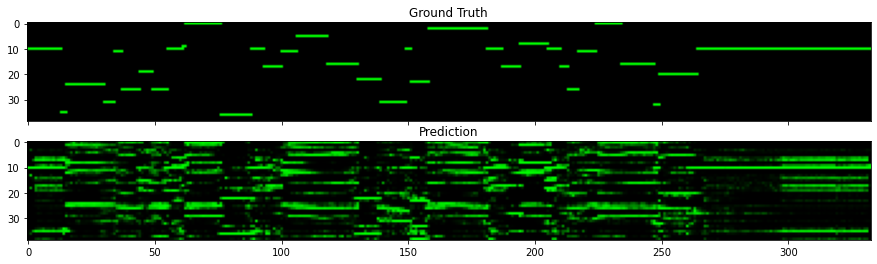

epoch 6: 100%|██████████| 4158/4158 [00:16<00:00, 253.63it/s, loss=  1.278]
2022-05-19 01:05:11.897 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.498 Accuracy: 62.0% Precision: 62.0% Recall: 0.620 F1: 0.620


Wav File: DR3_MGAF0_SX382.WAV Accuracy: 57.84%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 23, 23, 23, 23, 23,  8,  8,  8,  8,  8,  8, 
 8,  8,  8,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 10, 10, 23, 23, 23, 23, 26, 26, 26, 26, 22, 22, 
22, 22, 22, 10, 10, 10, 10, 10, 10, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
26, 26, 26, 31, 31, 31, 31,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 
 2,  2,  2, 32, 26, 26, 26, 26, 10, 10, 10, 10, 10,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 
 1,  1,  1, 32, 32, 26, 26, 26, 26, 26, 26, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 
18, 18, 18, 18, 18, 18, 30, 30, 30, 30, 30, 30, 10, 10, 10, 10, 38, 38, 38, 38, 38, 38, 16, 16, 16, 
16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 34, 34, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4, 
 4,  4,  4, 32, 32, 32, 26, 26

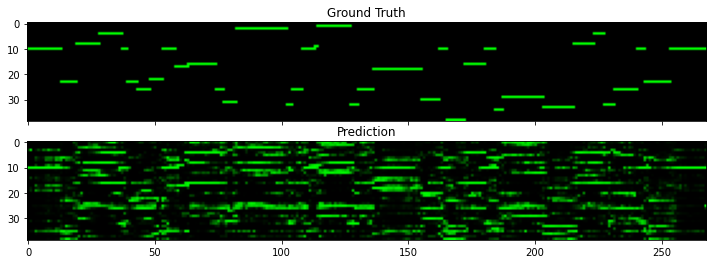

epoch 7: 100%|██████████| 4158/4158 [00:14<00:00, 283.15it/s, loss=  1.240]
2022-05-19 01:05:27.659 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.559 Accuracy: 61.6% Precision: 61.6% Recall: 0.616 F1: 0.616


Wav File: DR3_MJRH1_SA1.WAV Accuracy: 78.06%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 33, 33, 33, 33, 33, 33, 33, 33, 
33, 33, 33, 33, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10, 10, 10,  6,  6,  6,  6, 21, 21, 21, 21, 16, 16, 16, 16, 
16, 16, 16, 10, 10, 10, 10, 10,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4, 
 4,  4, 10, 10, 10, 10, 10, 10,  7,  7, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 30, 30, 
30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 10, 10, 10, 10, 10, 35, 35, 35, 35, 35, 
35, 35, 35, 35, 26, 26, 26, 26, 26, 26, 31, 31, 31, 31, 31, 10, 10, 10, 10, 34,  4,  4,  4,  4,  4, 
 4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 20, 20, 20, 
20, 20, 20, 20, 20, 20, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  8,  8,  8,  8,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8, 33, 

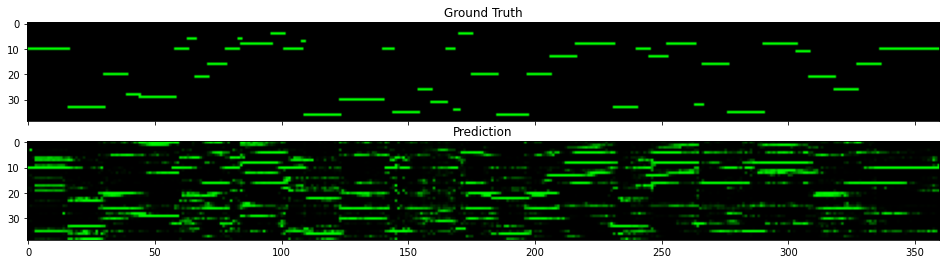

epoch 8: 100%|██████████| 4158/4158 [00:15<00:00, 269.56it/s, loss=  1.206]
2022-05-19 01:05:44.193 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.528 Accuracy: 61.7% Precision: 61.7% Recall: 0.617 F1: 0.617


Wav File: DR1_MKLS0_SX177.WAV Accuracy: 64.08%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6,  6, 25, 25, 25, 25, 25, 25, 25, 25, 
25, 25, 22, 22, 22, 22, 22, 22, 22, 22, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 
 7,  4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 24, 24, 24, 24, 24, 24, 24, 11, 
11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7, 37, 37, 37, 
37, 37, 37, 37, 10, 10,  7,  7,  7,  7,  7,  7,  7, 20, 20, 20, 20, 27, 27, 27, 27, 27, 27, 27, 27, 
27, 27, 27, 27, 21, 21, 21, 21, 21, 21, 21, 21, 30, 30, 30, 30, 30, 30, 30, 30, 22, 22, 22, 22, 22, 
22, 22, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 25, 25, 25, 25, 25, 25, 25, 25

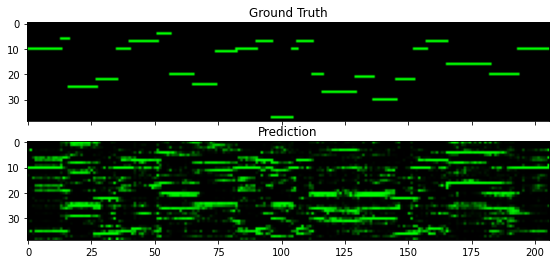

epoch 9: 100%|██████████| 4158/4158 [00:15<00:00, 268.14it/s, loss=  1.172]
2022-05-19 01:06:00.808 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.566 Accuracy: 61.1% Precision: 61.1% Recall: 0.611 F1: 0.611


Wav File: DR3_MRDS0_SX177.WAV Accuracy: 53.50%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6,  6, 25, 
25, 25, 25, 25, 25, 25, 22, 22, 22, 22, 22, 22, 22, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  4,  4, 
 4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 
11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7, 37, 37, 37, 37, 37, 37, 37, 10, 
 7,  7,  7,  7, 20, 20, 20, 20, 20, 20, 20, 20, 20, 27, 27, 27, 21, 21, 21, 21, 21, 21, 21, 21, 21, 
30, 30, 30, 30, 30, 30, 30, 22, 22, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35,  6,  0, 
 0, 26, 26, 26, 26

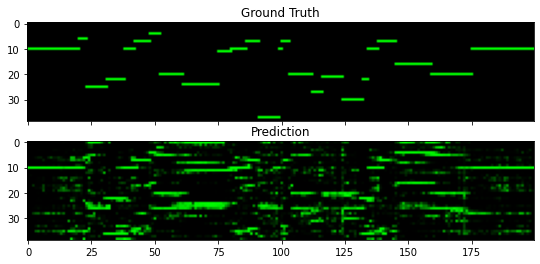

epoch 10: 100%|██████████| 4158/4158 [00:15<00:00, 268.57it/s, loss=  1.143]
2022-05-19 01:06:17.396 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.577 Accuracy: 61.0% Precision: 61.0% Recall: 0.610 F1: 0.610


Wav File: DR4_MJDC0_SX441.WAV Accuracy: 51.30%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6, 24, 24, 24, 24, 24, 24, 24, 24, 24, 
24, 31, 31, 31, 31, 31, 31, 11, 11, 11, 11, 11, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 10, 10, 10, 
10, 10, 18, 18, 18, 18, 18, 18, 18, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 10, 34,  4,  4,  4,  4, 
 4, 30, 30, 30, 30, 30, 30, 30, 30, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 29, 29, 21, 21, 21, 21, 21, 21, 21, 21, 26, 26, 10, 10, 10, 10, 10, 11, 11, 11, 11, 
11, 11, 11, 11, 11, 11, 11, 11, 22, 22, 22, 22, 22, 26, 26, 26, 26, 26, 26, 26, 26, 31, 25, 25, 25, 
25, 25, 10, 10, 10, 10, 10, 10, 10,  9,  9, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 27, 27, 27, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 15, 15,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 11, 11, 11, 
11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 
Predictio

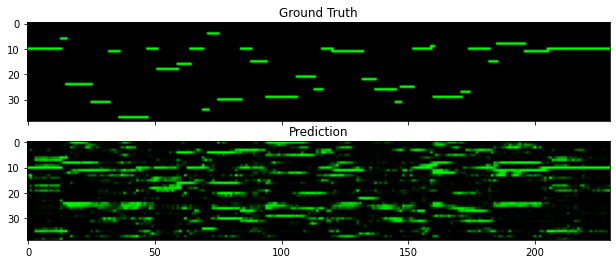

epoch 11: 100%|██████████| 4158/4158 [00:15<00:00, 268.02it/s, loss=  1.113]
2022-05-19 01:06:33.997 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.598 Accuracy: 60.9% Precision: 60.9% Recall: 0.609 F1: 0.609


Wav File: DR4_MFWK0_SX259.WAV Accuracy: 51.65%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 35, 35, 35,  8,  8,  8,  8,  8,  8,  8, 
 8,  8,  4,  4,  4,  4,  4, 31, 31,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 32, 
32, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 22, 22, 22, 22, 22, 22,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 18, 18, 18, 18, 18, 18, 18, 18, 31, 31, 31, 
31, 31, 31, 31,  6,  6,  6, 26, 26, 26, 26, 26, 26, 26, 36, 36, 36, 36, 10, 10, 10, 10, 10, 35, 35, 
35,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 35, 35, 35, 
35,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10,  7,  7,  7,  7,  7,  7, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 22, 22, 22, 22, 22, 22, 22, 25, 25, 25, 25, 18, 18, 18, 18, 18, 18, 
18, 18, 18, 18, 18, 18,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4, 
 4,  3,  3,  3,  3,  3,  3,  3

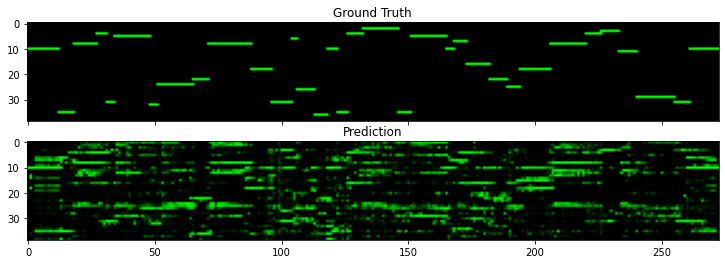

epoch 12: 100%|██████████| 4158/4158 [00:14<00:00, 281.54it/s, loss=  1.087]
2022-05-19 01:06:49.882 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.658 Accuracy: 60.5% Precision: 60.5% Recall: 0.605 F1: 0.605


Wav File: DR4_MDCD0_SI1415.WAV Accuracy: 67.75%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  5,  5,  5,  5,  5,  5,  5, 
 5,  5,  5,  5, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
10, 10, 10, 10,  7,  7,  7,  7, 25, 25, 25, 31, 31, 31, 25, 25, 25, 25, 25, 25, 25, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 36, 36, 36, 10, 10, 10, 10, 
10, 35, 35, 35, 25, 25, 25, 25, 25, 31, 31, 10, 10, 10, 10,  3,  3,  3,  3,  3,  3,  3,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 13, 13, 13, 25, 25, 25, 
14, 14, 14, 14, 14, 10, 10, 10, 10, 10, 10, 35, 35, 35, 35, 35, 30, 30, 30, 30, 30, 30, 30, 30, 36, 
36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 10, 10, 17, 17, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
25, 31, 31, 31, 31, 10, 10, 10, 23, 23, 23, 26, 26, 26, 26, 26, 26, 26, 26, 22, 22, 22, 22, 22, 22, 
22, 22, 22, 22, 22, 10, 10, 1

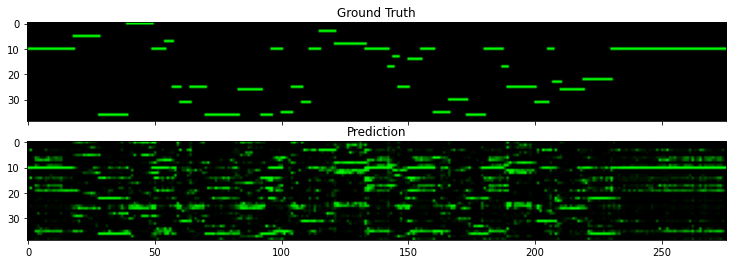

epoch 13: 100%|██████████| 4158/4158 [00:16<00:00, 255.06it/s, loss=  1.060]
2022-05-19 01:07:07.365 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.677 Accuracy: 60.8% Precision: 60.8% Recall: 0.608 F1: 0.608


Wav File: DR4_MPRK0_SI467.WAV Accuracy: 60.05%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 28, 20, 20, 20, 20, 20, 20, 20, 20,  4, 
 4,  4,  4,  4,  4,  4,  4,  4,  4, 26, 26, 26, 26, 26, 26, 26, 11, 11, 11, 11, 11, 11, 11, 11, 11, 
11, 11, 11, 20, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7, 
 7,  7,  4,  4,  4,  4, 30, 30, 30, 30, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 26, 26, 26, 26, 
26, 26, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 
12, 12, 12, 12, 12, 12, 12, 10, 10, 10,  6,  6,  6, 28, 28, 28, 28, 28, 28, 28, 26, 26, 26, 26, 26, 
26, 26, 26, 26, 26, 26, 26, 26, 26,  3,  3,  3,  3,  3,  3,  3,  3,  3, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 
31, 31, 31, 31, 31, 31, 31, 31,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 
11, 11, 11, 11, 11, 11, 11, 11

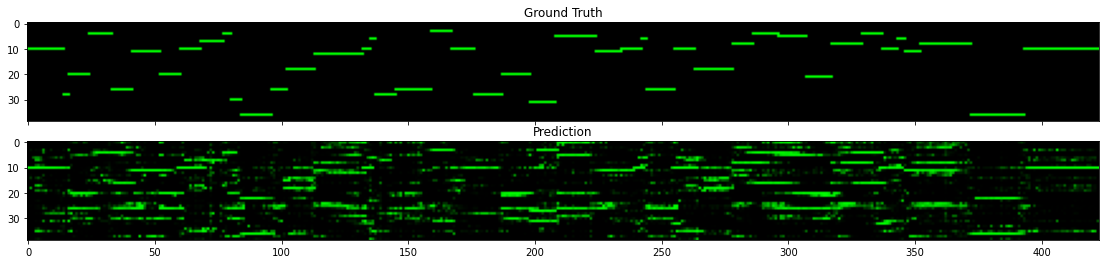

epoch 14: 100%|██████████| 4158/4158 [00:15<00:00, 262.53it/s, loss=  1.038]
2022-05-19 01:07:24.337 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.705 Accuracy: 60.2% Precision: 60.2% Recall: 0.602 F1: 0.602


Wav File: DR5_MJPG0_SX21.WAV Accuracy: 60.00%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,  8,  8, 11, 
11, 11, 11, 18, 18, 18, 18, 18, 18, 18, 18, 18,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 11, 11, 11, 
11, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 22, 22, 
22, 22, 22, 22, 22, 22, 22, 28, 28, 28, 28,  0,  0,  0,  0,  0,  0, 11, 11, 11, 14, 14, 14, 14, 14, 
14, 14, 14, 14, 14, 14, 20, 20, 20, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 16, 16, 
16, 16, 16, 16, 21, 21, 21, 21, 21, 21, 26, 26, 26, 26, 26, 26, 26, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25,  7, 35,  8,  8,  8,  8,  8, 26, 
11, 11, 36, 18, 18,

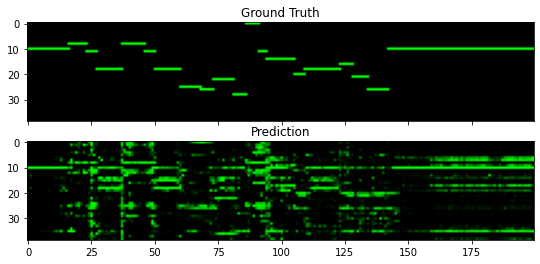

epoch 15: 100%|██████████| 4158/4158 [00:15<00:00, 273.71it/s, loss=  1.016]
2022-05-19 01:07:40.605 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.707 Accuracy: 60.4% Precision: 60.4% Recall: 0.604 F1: 0.604


Wav File: DR8_FBCG1_SX172.WAV Accuracy: 58.07%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 25, 25, 25, 25, 10, 10, 10, 35, 35, 
35, 35, 35, 35, 35, 35,  4,  4,  4,  4,  4, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 25, 25, 
25, 25, 25,  3,  3,  3, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 26, 26, 26, 26, 26, 26, 31, 31, 
35, 35, 13, 13, 13, 13, 13, 13, 13, 13, 13,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4, 
 4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
35, 35, 35, 26, 26, 26, 10, 10, 10, 10, 10, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 26, 26, 26, 
15, 15, 15, 26, 26, 26, 26, 26, 32, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 31, 31, 31, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 
12, 12, 12, 12, 20, 20, 20, 20

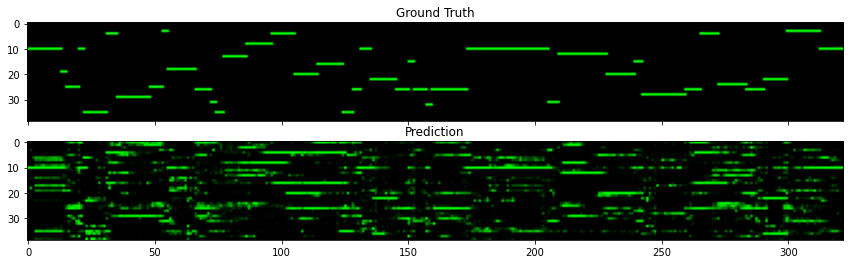

epoch 16: 100%|██████████| 4158/4158 [00:16<00:00, 259.65it/s, loss=  0.994]
2022-05-19 01:07:57.757 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.753 Accuracy: 60.1% Precision: 60.1% Recall: 0.601 F1: 0.601


Wav File: DR4_FKDW0_SX217.WAV Accuracy: 52.43%
Ground Truth:
10, 10, 10, 10, 10, 10, 28, 28, 28, 28, 28, 28, 28,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  3,  3, 
 3,  3,  3,  3,  3, 26, 26, 26, 31, 31, 31, 31, 31,  0,  0,  0,  0,  0,  0, 35, 35, 35, 35, 35, 35, 
35, 35, 35, 35, 35, 35,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4, 19, 19, 19, 19, 19,  0,  0, 
 0,  0,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0, 
 0,  0, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 
10, 10, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7, 16, 25, 12,  8,  8,  1,  1, 25, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 17, 17, 17, 28, 17,  4,  4,  4, 16,  8,  4,  4,  4

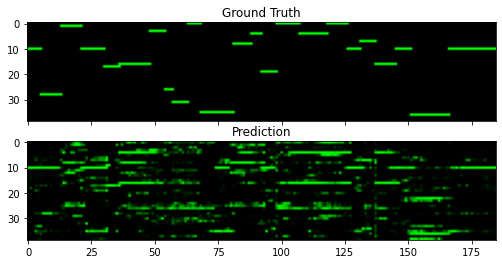

epoch 17: 100%|██████████| 4158/4158 [00:15<00:00, 261.66it/s, loss=  0.975]
2022-05-19 01:08:14.710 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.810 Accuracy: 59.6% Precision: 59.6% Recall: 0.596 F1: 0.596


Wav File: DR8_FMBG0_SX3.WAV Accuracy: 70.05%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 
26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 
10, 13, 13, 25, 25, 25, 25, 25, 25, 25, 22, 22, 22, 22, 22, 22, 22, 22, 20, 20, 20, 20, 20, 20, 20, 
20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 18, 18, 
18, 18, 18, 18, 18, 18, 18, 18, 18,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4, 
 4,  4,  4, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 36, 36, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7, 10, 10, 10, 10, 10, 17, 17, 19, 
20, 26, 26, 26, 26,  0,  0, 26, 26, 26, 36, 36, 36, 36, 36, 36, 36, 36, 

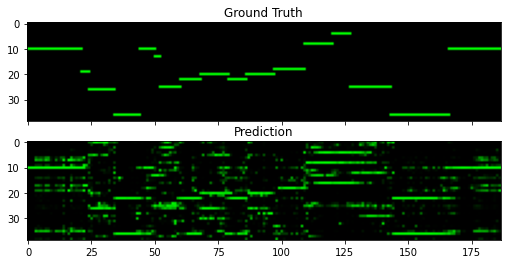

epoch 18: 100%|██████████| 4158/4158 [00:14<00:00, 277.94it/s, loss=  0.957]
2022-05-19 01:08:30.729 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.808 Accuracy: 59.4% Precision: 59.4% Recall: 0.594 F1: 0.594


Wav File: DR8_FCLT0_SI1438.WAV Accuracy: 49.30%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 20, 20, 20, 20, 20, 20, 
20, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 22,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 11, 
11, 11, 11, 11, 13, 13, 13, 13, 13, 26, 26, 26, 26, 26, 26, 26, 26, 22, 22, 22, 22, 22, 22, 22, 10, 
10, 10, 10,  7,  7,  7,  7,  7, 26, 31, 31, 31, 31, 31, 10, 10, 10, 10, 10, 35, 35, 35, 35, 35, 35, 
 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 31, 31, 31,  3,  3,  3,  3, 
 3,  3, 26, 26, 26, 10, 10, 10, 10, 10, 10, 35, 35, 35, 35, 35, 35, 35, 29, 29, 29, 29, 29, 29, 29, 
29, 29, 29, 29, 11, 11, 11, 11, 11, 11, 11, 26, 26, 26, 26, 26, 10, 10, 10, 10, 10,  7,  7,  7,  7, 
 7, 26, 26, 26, 27, 27, 27, 27, 27, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7, 11, 11, 11, 
11, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 33, 33, 33, 33, 33, 33, 33, 26, 
26, 26, 26, 26, 26, 31, 31, 3

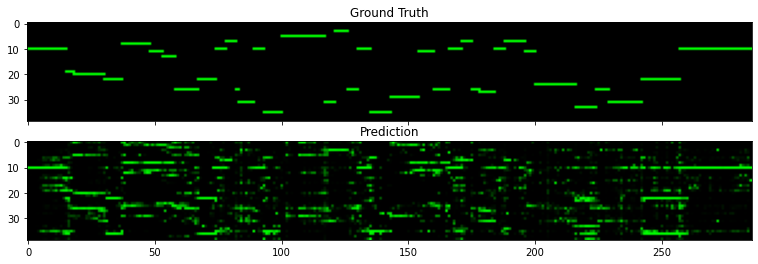

epoch 19: 100%|██████████| 4158/4158 [00:16<00:00, 254.55it/s, loss=  0.939]
2022-05-19 01:08:48.183 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.826 Accuracy: 59.5% Precision: 59.5% Recall: 0.595 F1: 0.595


Wav File: DR5_MREW1_SX150.WAV Accuracy: 72.49%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 15, 15, 15, 20, 20, 20, 20, 20, 20, 20, 
 0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 10, 10,  3,  3,  3,  3,  3, 25, 25, 25, 25, 25, 25, 25, 31, 
31, 31, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 22, 22, 
22, 22, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7, 13, 13, 25, 25, 25, 22, 22, 22, 22, 22, 22, 22, 
22, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
20, 31, 31, 31, 26, 26, 26, 26, 26, 26, 26, 26, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 26, 26, 26, 
26, 10, 10, 10, 10, 10,  7,  7, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10,  7,  7,  7,  7, 13, 13, 
13, 13, 26, 26, 26, 26, 26, 26, 22, 22, 22, 22, 22, 22, 26, 26, 26, 26, 26, 26, 26, 26, 26, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 
Prediction:
1

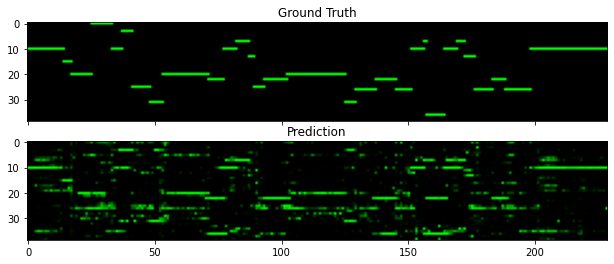

In [10]:
model = Segmentor(cfg).cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

if os.path.exists(cfg.ckpt_path) and cfg.re_train:
    model.load_state_dict(torch.load(cfg.ckpt_path))
    logger.info('Model loaded from checkpoint.')
else:
    logger.info('Model initiated.')

logger.info('Training started.')
print('----------------------------')
results = []
for epoch in range(cfg.epochs):
    train_loss = train_loop(epoch, train_dataloader, model, loss, optimizer)
    val_loss, val_acc, val_pre, val_recall, val_f1 = validate(val_dataloader, model, loss)
    results.append([epoch, train_loss, val_loss, val_acc, val_pre, val_recall, val_f1])

if not cfg.dev_run:
    with open(cfg.report_path, 'w', encoding='utf-8') as fw:
        fw.writelines([','.join([str(i) for i in result]) + '\n' for result in results])
    torch.save(model.state_dict(), cfg.ckpt_path)

### Test

#### Load test data

In [12]:
test_dataset = TimitDataset.get_test_dataset(cfg.dataset_path, cfg)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_pad)

2022-05-19 01:39:00.944 | INFO     | data_processing:__init__:77 - Loading 1 files into cache ...
100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


#### Run test

2022-05-19 01:39:05.326 | INFO     | __main__:<module>:6 - Model loaded from checkpoint.
2022-05-19 01:39:07.044 | INFO     | __main__:validate:63 - Val Result: Avg loss:   0.651 Accuracy: 81.5% Precision: 81.5% Recall: 0.815 F1: 0.815


Wav File: DR5_MEGJ0_SA1.WAV Accuracy: 81.47%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 33, 33, 33, 33, 33, 33, 33, 33, 33, 
33, 33, 33, 33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 
29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 23, 23, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4, 
 4,  4,  4,  4,  4,  4,  4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 36, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 
30, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 26, 26, 26, 26, 26, 26, 26, 31, 31, 31, 31, 31, 
31, 10, 10, 10, 10, 10, 10, 10, 34,  4,  4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
20, 22, 22, 22, 22, 22, 22, 22, 

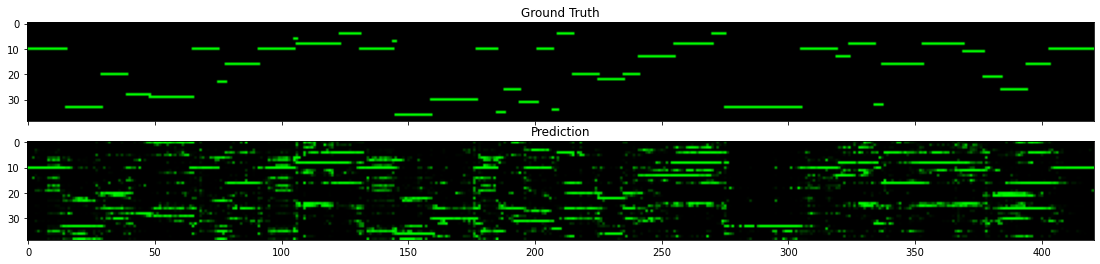

In [13]:
model = Segmentor(cfg).cuda()
if not os.path.exists(cfg.ckpt_path):
    logger.error('No available checkpoint file found, exiting ...')
else:
    model.load_state_dict(torch.load(cfg.ckpt_path))
    logger.info('Model loaded from checkpoint.')

    validate(test_dataloader, model, torch.nn.CrossEntropyLoss())